<br><br><br>

<h1><font color="#7F000E" size=6>Proyecto de Clasificación de Género Musical con Machine Learning</font></h1>

<br>
<div style="text-align: right">
<font color="#7F000E" size=3>Francisco Gamarra</font><br>
<font color="#7F000E" size=3>Luis Tejada</font><br>
</div>

Importamos las librerias

In [3]:
#!pip install tensorflow

import os
import numpy
from tensorflow import keras
import librosa
from matplotlib import pyplot
import librosa.display
import IPython.display

Creamos la funccion para obtener el MFCC (Mel Frequency Cepstral Coefficients)

In [4]:
#Se crea la función MFCC con la ayuda de LIBROSA

def get_mfcc(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  mfcc = numpy.array(librosa.feature.mfcc(y=y, sr=sr))
  return mfcc

Aplicamos la funcion sobre un audio en particular para ver sus características

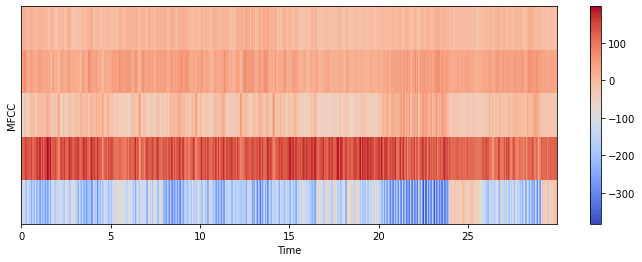

In [6]:
#Se coge el audio segmentado de 30 segundos y se muestra su

example_file = "dataset/salsa/salsa.00015.wav"
y, sr = librosa.load(example_file, offset=0, duration=30)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=5)
pyplot.figure(figsize=(12,4))
librosa.display.specshow(mfcc, x_axis='time')
pyplot.ylabel('MFCC')
pyplot.colorbar()

Creamos la funcion para hallar el Espectrograma de Mel

In [7]:
def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  melspectrogram = numpy.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

Observamos el espectrograma de Mel en la pieza seleccionada

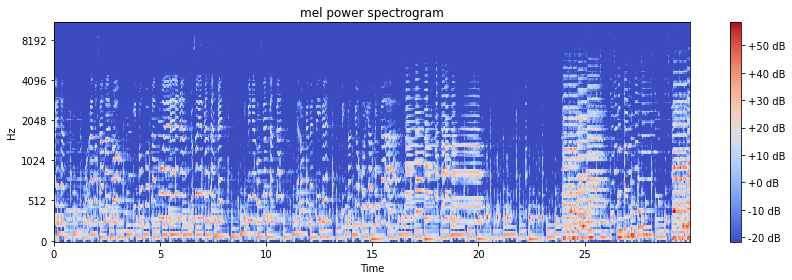

In [8]:
y, sr = librosa.load(example_file, offset=0, duration=30)
melspectrogram = numpy.array(librosa.feature.melspectrogram(y=y, sr=sr))
log_S = librosa.amplitude_to_db(melspectrogram)
pyplot.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
pyplot.title('mel power spectrogram')
pyplot.colorbar(format='%+02.0f dB')
pyplot.tight_layout()

Creamos la función para hallar el Vector de Cromaticidad

In [9]:
def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = numpy.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

Aplicamos la función para hallar las características cromáticas de la pieza

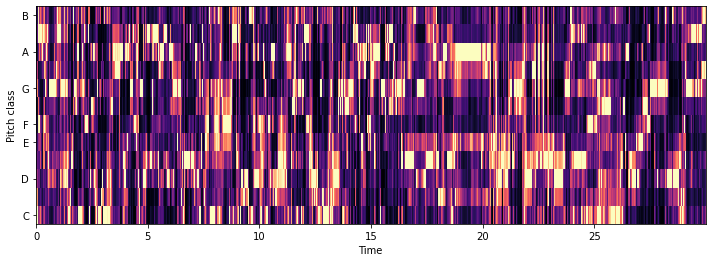

In [10]:
y, sr = librosa.load(example_file)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
pyplot.figure(figsize=(12,4))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')

Creamos la función para hallar los Centroides Tonales

In [11]:
def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = numpy.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

Aplicamos la función para ver alrededor de qué tonalidades se mueve la pieza

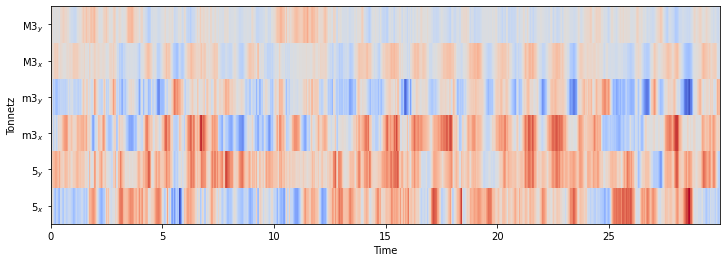

In [12]:
y, sr = librosa.load(example_file)
tntz = librosa.feature.tonnetz(y=y, sr=sr)
pyplot.figure(figsize=(12,4))
librosa.display.specshow(tntz, sr=sr, x_axis='time', y_axis='tonnetz')

Creamos una función para agrupar estas 4 características en un vector de una pieza musical

In [13]:
def get_feature(file_path):
  # Extracting MFCC feature
  mfcc = get_mfcc(file_path)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = numpy.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # Extracting Mel Spectrogram feature
  melspectrogram = get_melspectrogram(file_path)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  melspectrogram_min = melspectrogram.min(axis=1)
  melspectrogram_max = melspectrogram.max(axis=1)
  melspectrogram_feature = numpy.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

  # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)
  chroma_min = chroma.min(axis=1)
  chroma_max = chroma.max(axis=1)
  chroma_feature = numpy.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # Extracting tonnetz feature
  tntz = get_tonnetz(file_path)
  tntz_mean = tntz.mean(axis=1)
  tntz_min = tntz.min(axis=1)
  tntz_max = tntz.max(axis=1)
  tntz_feature = numpy.concatenate( (tntz_mean, tntz_min, tntz_max) ) 
  
  feature = numpy.concatenate( (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature) )
  return feature

Calculamos las características por cada una de las piezas musicales de nuestro dataset

In [15]:
directory = 'dataset'
genres = ['salsa','classical','rock','reggaeton']
features = []
labels = []
for genre in genres:
    print("Calculando caracteristicas para el genero : " + genre)
    for file in os.listdir(directory+"/"+genre):
        file_path = directory+"/"+genre+"/"+file

        features.append(get_feature(file_path))
        label = genres.index(genre)
        labels.append(label)

Calculando caracteristicas para el genero : salsa
Calculando caracteristicas para el genero : classical
Calculando caracteristicas para el genero : rock
Calculando caracteristicas para el genero : reggaeton


Separamos el conjunto de datos que vamos a usar para entrenamiento, validación y prueba

In [16]:
permutations = numpy.random.permutation(400)
features = numpy.array(features)[permutations]
labels = numpy.array(labels)[permutations]

features_train = features[0:280]
labels_train = labels[0:280]

features_val = features[280:340]
labels_val = labels[280:340]

features_test = features[340:400]
labels_test = labels[340:400]

Entrenamos una red neuronal con 498 neuronas de entrada, 300 y 200 en las capas intermedias y 3 en la capa de salida

In [17]:
inputs = keras.Input(shape=(498), name="feature")
x = keras.layers.Dense(300, activation="relu", name="dense_1")(inputs)
x = keras.layers.Dense(300, activation="relu", name="dense_2")(x)
outputs = keras.layers.Dense(4, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
model.fit(x=features_train.tolist(),y=labels_train.tolist(),verbose=1,validation_data=(features_val.tolist() , labels_val.tolist()), epochs=200)

Epoch 1/200
9/9 [==============================] - 1s 45ms/step - loss: 126.0164 - sparse_categorical_accuracy: 0.4893 - val_loss: 24.9176 - val_sparse_categorical_accuracy: 0.6667
Epoch 2/200
9/9 [==============================] - 0s 10ms/step - loss: 19.3009 - sparse_categorical_accuracy: 0.7464 - val_loss: 13.0838 - val_sparse_categorical_accuracy: 0.6500
Epoch 3/200
9/9 [==============================] - 0s 9ms/step - loss: 6.1572 - sparse_categorical_accuracy: 0.8429 - val_loss: 11.7907 - val_sparse_categorical_accuracy: 0.6333
Epoch 4/200
9/9 [==============================] - 0s 9ms/step - loss: 9.7745 - sparse_categorical_accuracy: 0.8536 - val_loss: 10.0022 - val_sparse_categorical_accuracy: 0.7000
Epoch 5/200
9/9 [==============================] - 0s 9ms/step - loss: 2.9974 - sparse_categorical_accuracy: 0.9036 - val_loss: 49.5141 - val_sparse_categorical_accuracy: 0.5500
Epoch 6/200
9/9 [==============================] - 0s 9ms/step - loss: 10.6418 - sparse_categorical_accur

9/9 [==============================] - 0s 9ms/step - loss: 6.3862e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.2936 - val_sparse_categorical_accuracy: 0.8167
Epoch 47/200
9/9 [==============================] - 0s 9ms/step - loss: 6.3862e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.2876 - val_sparse_categorical_accuracy: 0.8167
Epoch 48/200
9/9 [==============================] - 0s 9ms/step - loss: 5.9605e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.2820 - val_sparse_categorical_accuracy: 0.8167
Epoch 49/200
9/9 [==============================] - 0s 9ms/step - loss: 5.5347e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.2768 - val_sparse_categorical_accuracy: 0.8167
Epoch 50/200
9/9 [==============================] - 0s 9ms/step - loss: 5.1090e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.2717 - val_sparse_categorical_accuracy: 0.8167
Epoch 51/200
9/9 [==============================] - 0s 9ms/step - loss: 5.1090e-09 - sparse_categorical

9/9 [==============================] - 0s 9ms/step - loss: 2.1287e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.1571 - val_sparse_categorical_accuracy: 0.8333
Epoch 92/200
9/9 [==============================] - 0s 9ms/step - loss: 1.7030e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.1556 - val_sparse_categorical_accuracy: 0.8333
Epoch 93/200
9/9 [==============================] - 0s 9ms/step - loss: 1.7030e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.1542 - val_sparse_categorical_accuracy: 0.8333
Epoch 94/200
9/9 [==============================] - 0s 9ms/step - loss: 1.7030e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.1528 - val_sparse_categorical_accuracy: 0.8333
Epoch 95/200
9/9 [==============================] - 0s 9ms/step - loss: 1.7030e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.1514 - val_sparse_categorical_accuracy: 0.8333
Epoch 96/200
9/9 [==============================] - 0s 9ms/step - loss: 1.7030e-09 - sparse_categorical

Epoch 136/200
9/9 [==============================] - 0s 10ms/step - loss: 1.2772e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.1005 - val_sparse_categorical_accuracy: 0.8333
Epoch 137/200
9/9 [==============================] - 0s 10ms/step - loss: 1.2772e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.0994 - val_sparse_categorical_accuracy: 0.8333
Epoch 138/200
9/9 [==============================] - 0s 10ms/step - loss: 1.2772e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.0983 - val_sparse_categorical_accuracy: 0.8333
Epoch 139/200
9/9 [==============================] - 0s 9ms/step - loss: 1.2772e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.0972 - val_sparse_categorical_accuracy: 0.8333
Epoch 140/200
9/9 [==============================] - 0s 9ms/step - loss: 1.2772e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.0961 - val_sparse_categorical_accuracy: 0.8333
Epoch 141/200
9/9 [==============================] - 0s 9ms/step - loss: 1.2772e-0

Epoch 181/200
9/9 [==============================] - 0s 9ms/step - loss: 8.5149e-10 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.0555 - val_sparse_categorical_accuracy: 0.8333
Epoch 182/200
9/9 [==============================] - 0s 9ms/step - loss: 8.5149e-10 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.0548 - val_sparse_categorical_accuracy: 0.8333
Epoch 183/200
9/9 [==============================] - 0s 9ms/step - loss: 8.5149e-10 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.0541 - val_sparse_categorical_accuracy: 0.8333
Epoch 184/200
9/9 [==============================] - 0s 9ms/step - loss: 8.5149e-10 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.0533 - val_sparse_categorical_accuracy: 0.8333
Epoch 185/200
9/9 [==============================] - 0s 9ms/step - loss: 8.5149e-10 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.0526 - val_sparse_categorical_accuracy: 0.8333
Epoch 186/200
9/9 [==============================] - 0s 9ms/step - loss: 8.5149e-10 -

Evaluamos la eficiencia del modelo

In [18]:
score = model.evaluate(x=features_test.tolist(),y=labels_test.tolist(), verbose=0)
print('Accuracy : ' + str(score[1]*100) + '%')

Accuracy : 88.33333253860474%


In [19]:
from sklearn.metrics import confusion_matrix

y_prediction = model.predict(features_test.tolist())

2/2 [==============================] - 0s 3ms/step


In [20]:
y_prediction = numpy.argmax (y_prediction, axis = 1)
result = confusion_matrix(labels_test, y_prediction , normalize='pred')

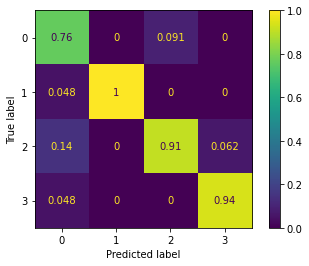

In [21]:
from sklearn import metrics

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = result)

cm_display.plot()

Tomamos un audio a evaluar

In [29]:
import librosa

audioName = 'Oscar De Leon – Lloraras.mp3'

audio_y , sample_rate = librosa.load(audioName, sr=None)

Obtenemos los primeros 30 segundos del audio

In [30]:
start = ['00:00']
end = ['00:30']

#Función para convertir el string en entero (segundos)
def str2num(cadena):
    return int(cadena[0:2])*60 + int(cadena[3:5])

import scipy.io.wavfile

segmentName=[]

segmentName.append(audioName.split(".")[0]+"_30s.wav")

t0 = sample_rate * str2num(start[0])
tf = sample_rate * str2num(end[0])
scipy.io.wavfile.write(segmentName[0], sample_rate, audio_y[t0:tf])

import IPython.display as ipd

ipd.display(ipd.Audio(segmentName[0]))

Evaluamos el audio de acuerdo al modelo y obtenemos el genero musical

In [31]:
file_path = audioName.split(".")[0]+"_30s.wav"
feature = get_feature(file_path)
y = model.predict(feature.reshape(1,498))
print(y)

1/1 [==============================] - 0s 17ms/step
[[1. 0. 0. 0.]]


In [32]:
numpy.max(y)

1.0

In [33]:
if(numpy.max(y)>0.90):
    ind = numpy.argmax(y)
    print(f"Esta canción es del género: {genres[ind]}")
else:
    print(f"Esta canción es de otro género no entrenado")

Esta canción es del género: salsa
